In [64]:



def calc_mag(u, v):
    ct = 0.0
    inc = 3
    total = 0.0

    for i in range(0, u.shape[0], 8):
        for j in range(0, u.shape[1],8):
            fy = v[i,j] * inc
            fx = u[i,j] * inc
            ct += 1
            calc = (fx**2 + fy**2)**0.5
            total += calc

    avg = total / ct

    return avg


def draw_quiver2(frame,u,v):

    scale = 1
    #ax = plt.figure().gca()
    fig, (ax1) = plt.subplots(1, 1)
    ax1.axis("Off")

    canvas = plt.gca().figure.canvas
    canvas.draw()

    ax1.imshow(frame)
    value = calc_mag(u, v)

    for i in range(0, u.shape[0], 9):
        for j in range(0, u.shape[1],9):
            dy = v[i,j] * scale
            dx = u[i,j] * scale
            calc = (dx**2 + dy**2)**0.5
            if calc > (value*0.1):
              ax1.quiver(j,i,dx,dy,  angles='xy', scale_units='xy', scale=0.005, color='green')


    plt.draw()
    plt.show()
    plt.axis('off')
    ax1.axis("Off")
    fig.savefig('./temp.jpg', dpi=300, bbox_inches='tight')
    img_frame = cv2.imread('./temp.jpg')
    img_frame = cv2.cvtColor(img_frame, cv2.COLOR_BGR2RGB)
    return cv2.resize(img_frame, (frame.shape[1], frame.shape[0]))


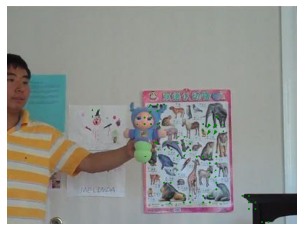

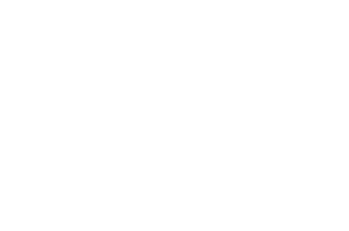

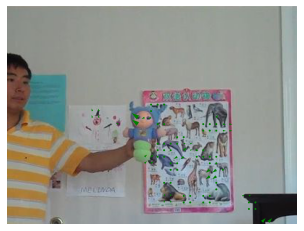

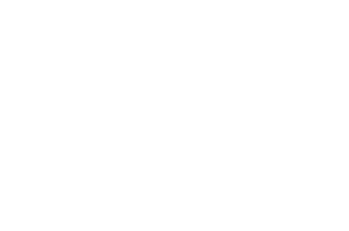

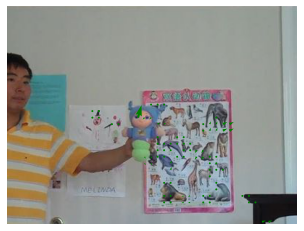

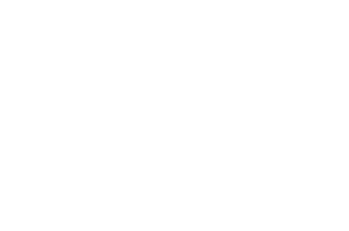

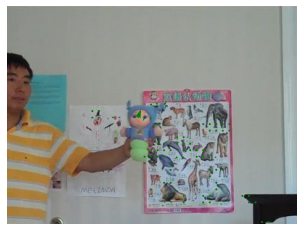

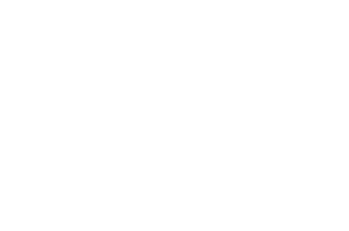

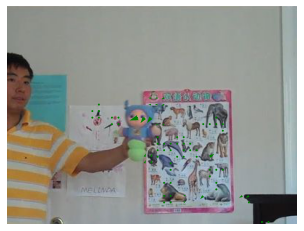

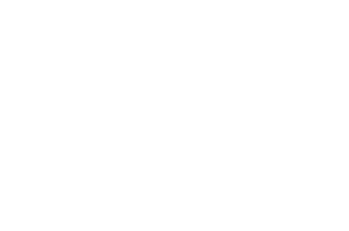

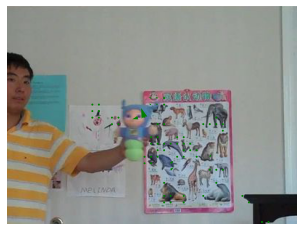

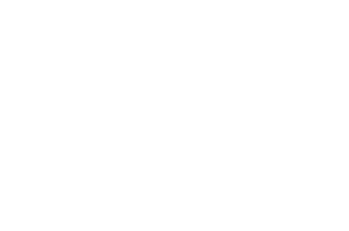

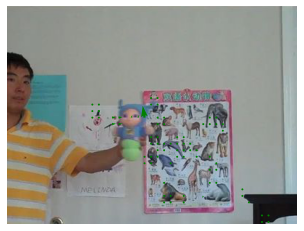

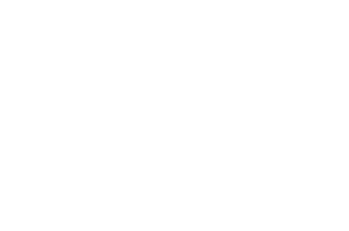

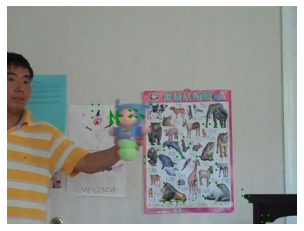

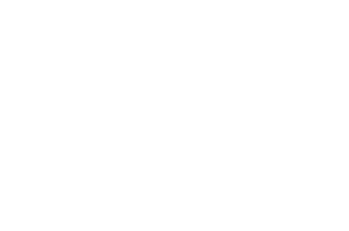

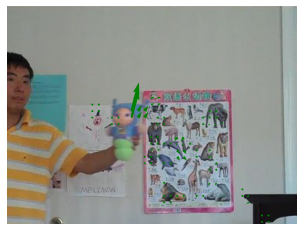

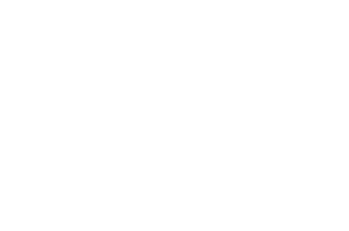

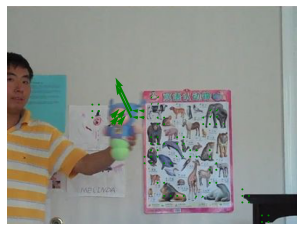

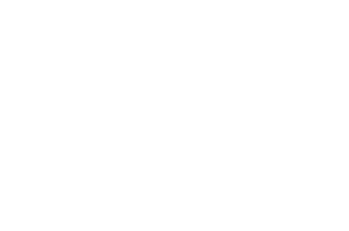

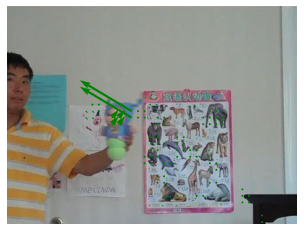

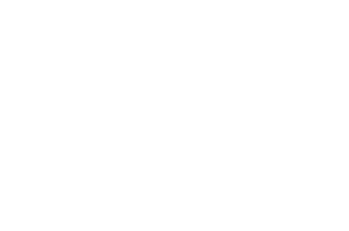

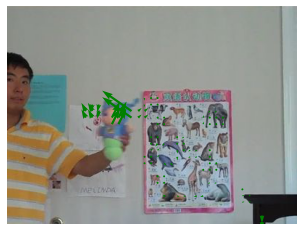

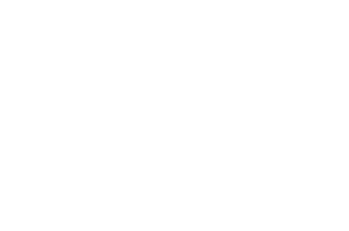

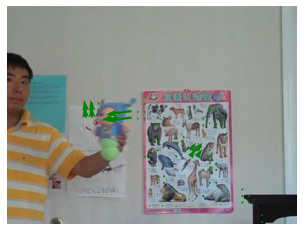

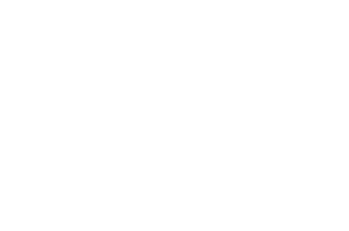

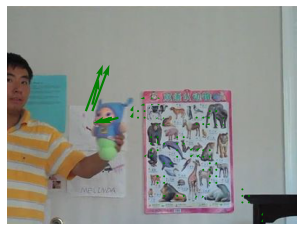

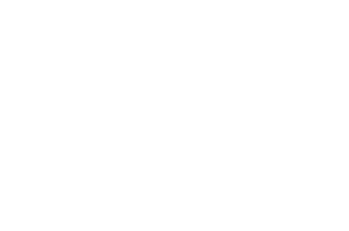

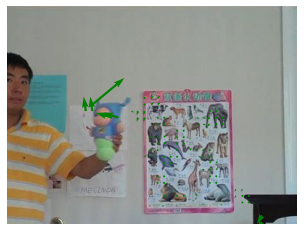

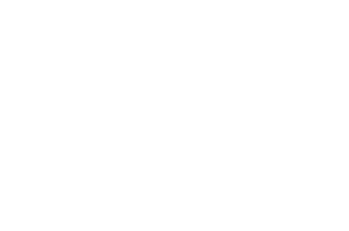

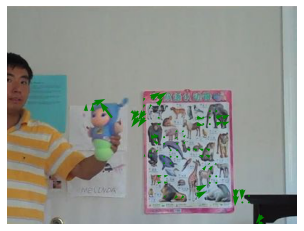

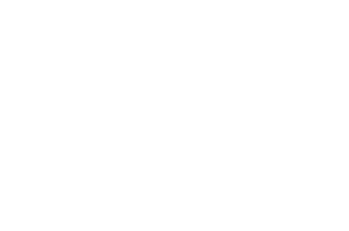

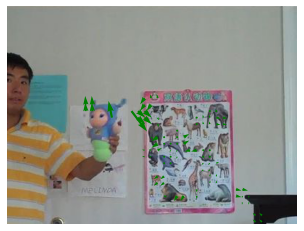

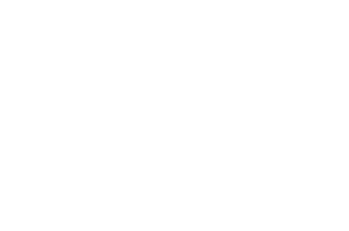

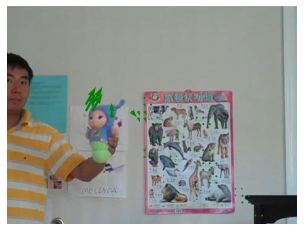

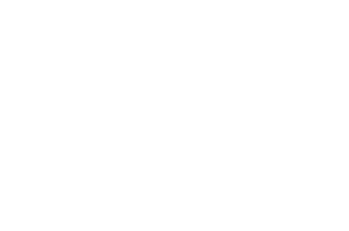

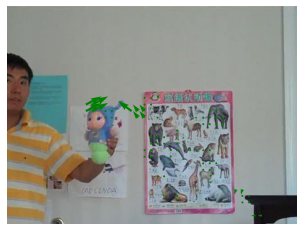

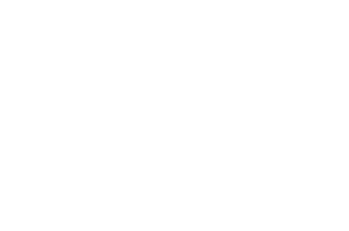

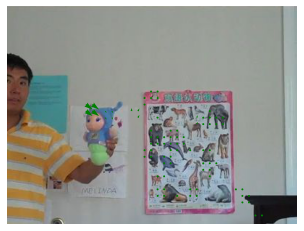

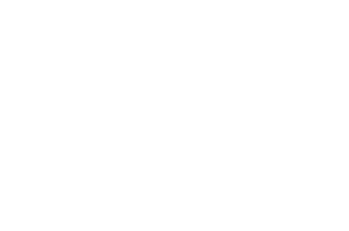

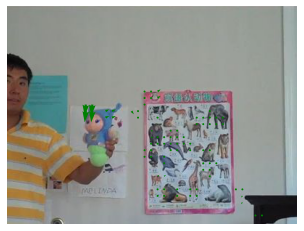

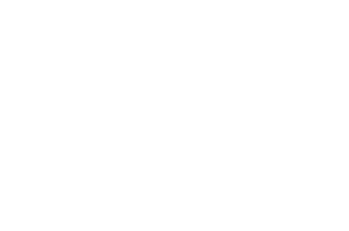

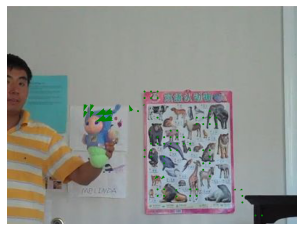

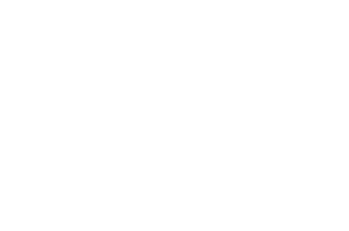

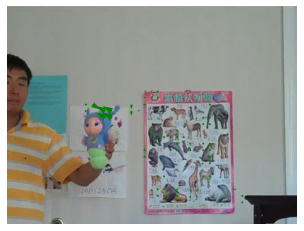

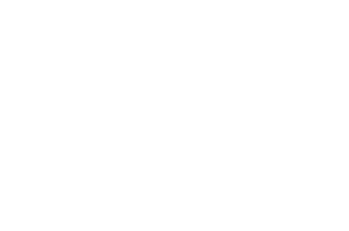

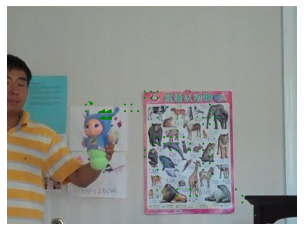

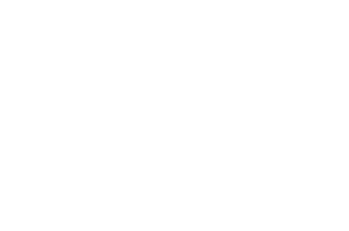

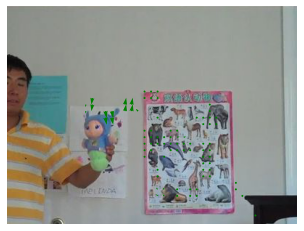

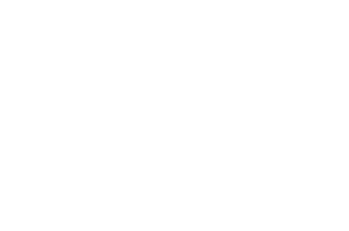

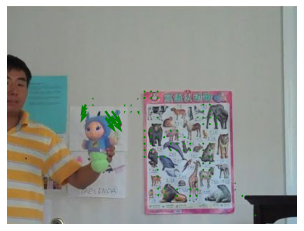

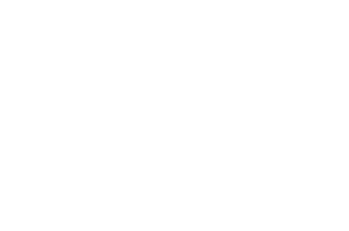

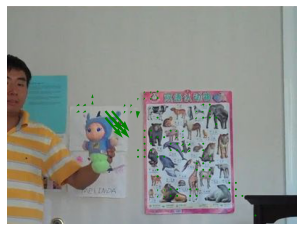

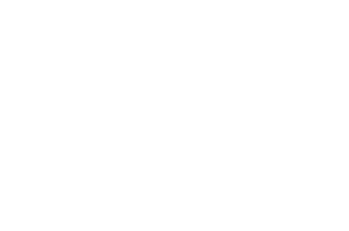

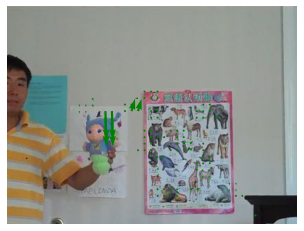

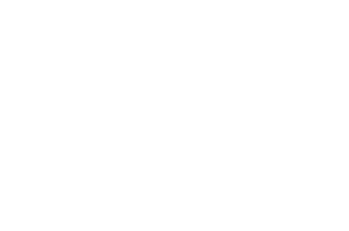

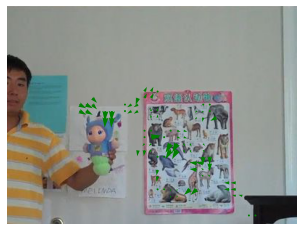

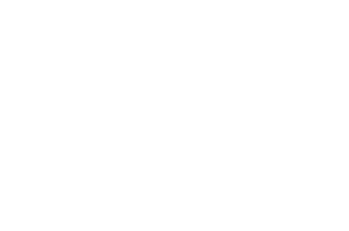

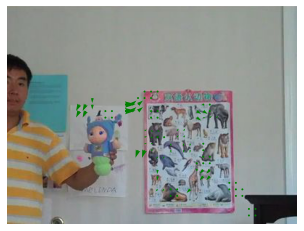

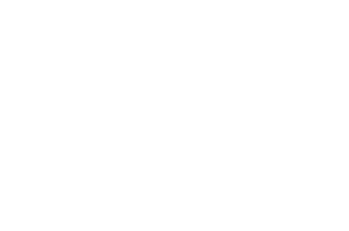

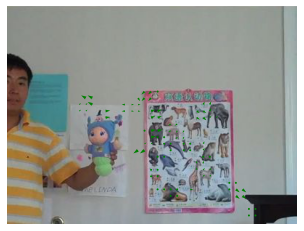

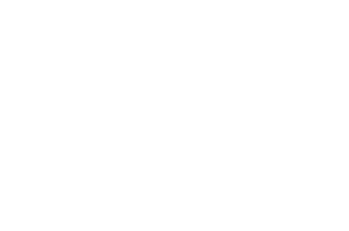

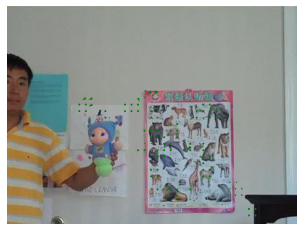

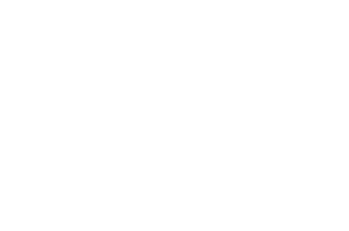

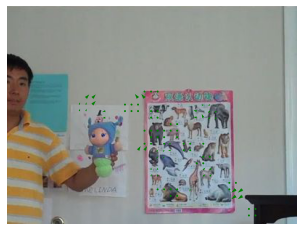

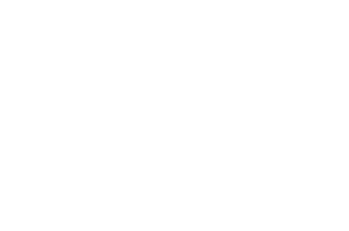

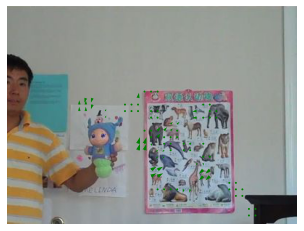

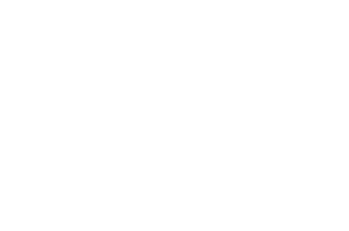

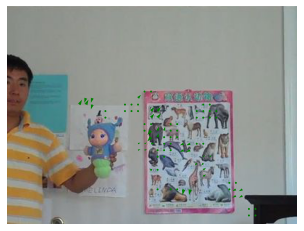

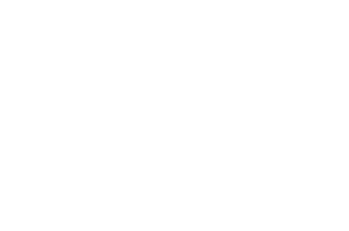

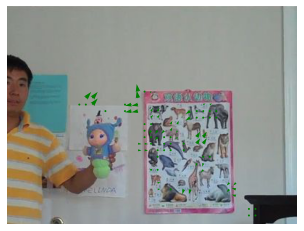

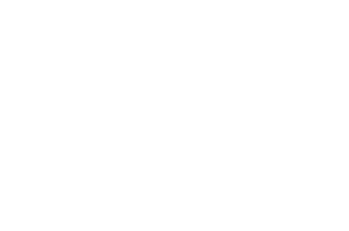

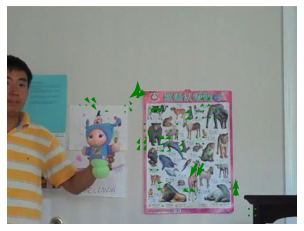

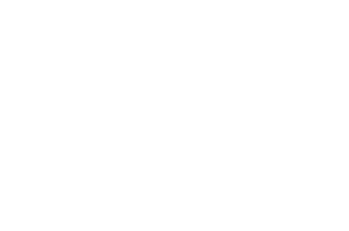

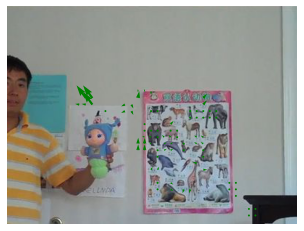

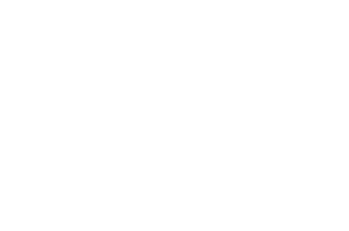

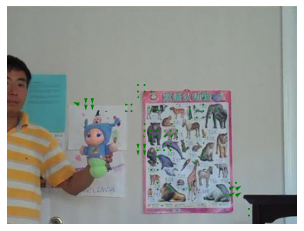

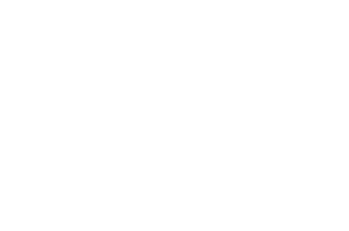

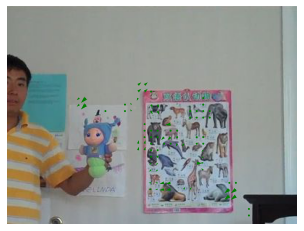

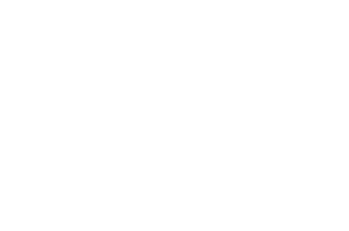

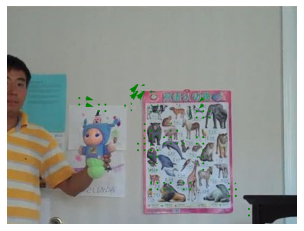

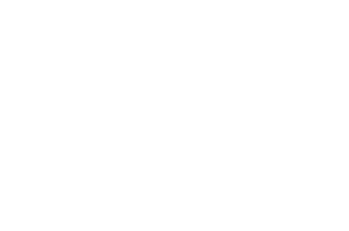

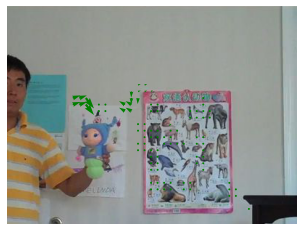

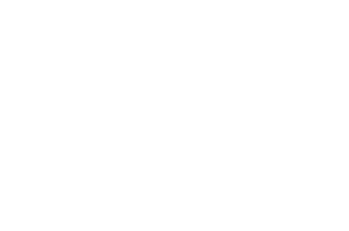

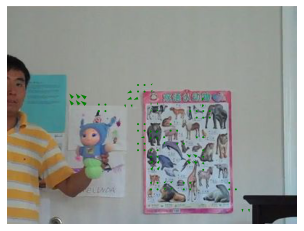

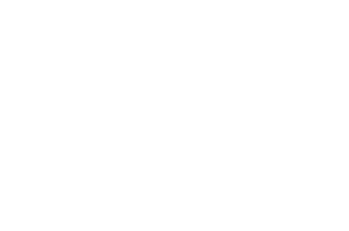

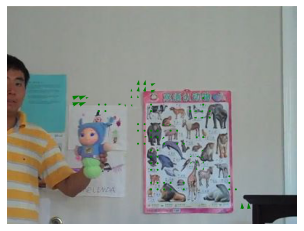

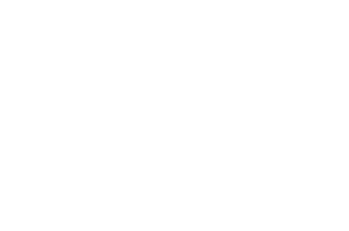

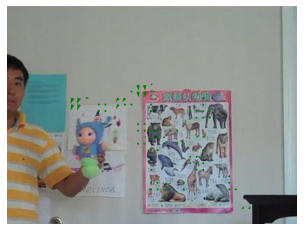

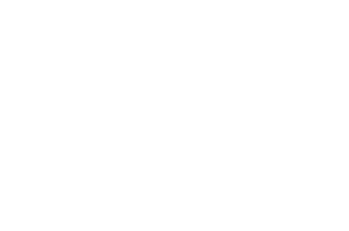

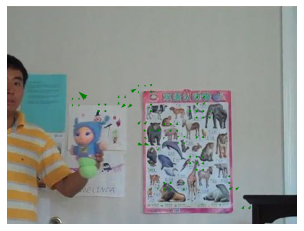

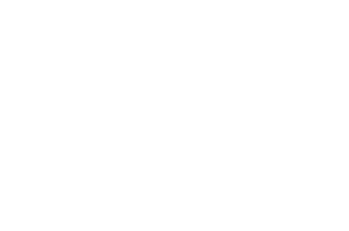

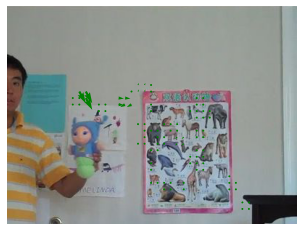

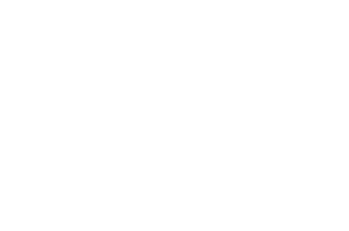

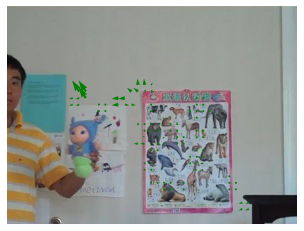

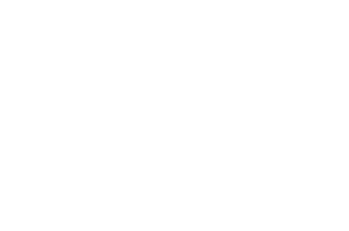

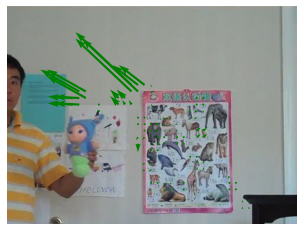

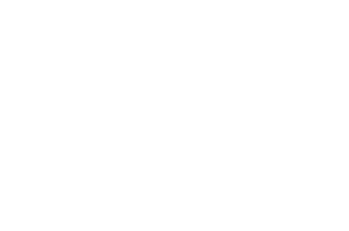

In [65]:
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from scipy.ndimage import gaussian_filter, convolve


def save_video(filename, array, fps=10):
    N, H, W, C = array.shape
    video = cv2.VideoWriter(
        filename,
        cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'),
        fps,
        (W, H),
        False
    )

    for i in range(array.shape[0]):
        video.write(array[i, :, :, :].astype('uint8'))
    video.release()


def draw_quiver(frame, u, v):
    plt.figure()
    plt.axis('off')
    plt.imshow(frame, cmap='gray', interpolation='bicubic')

    a, b = np.meshgrid(
        np.arange(0, frame.shape[1]),
        np.arange(0, frame.shape[0]),
    )
    plt.quiver(
        a[::15, ::15], b[::15, ::15],
        u[::15, ::15], v[::15, ::15],
        color='r',  angles='xy', scale_units='xy', scale=1e-3,
    )
    
    plt.savefig('./temp.jpg', dpi=300, bbox_inches='tight')
    new_frame = mpimg.imread('./temp.jpg')
    os.remove('./temp.jpg')

    return cv2.resize(new_frame, (frame.shape[1], frame.shape[0]))


def harris_corner_detector(I, k=0.04, window_size=5, threshold=1e-5):
    # image preprocessing
    if I.ndim == 3:
        I = cv2.cvtColor(I, cv2.COLOR_RGB2GRAY)

    I = I / I.max()

    # compute the first order derivates at every pixel
    Ix = gaussian_filter(I, 1, order=(0, 1))
    Iy = gaussian_filter(I, 1, order=(1, 0))

    # compute the products of derivatives at every pixel
    Ix2 = Ix * Ix
    Ixy = Ix * Iy
    Iy2 = Iy * Iy

    # average over local window
    Sx2 = gaussian_filter(Ix2, 2)
    Sxy = gaussian_filter(Ixy, 2)
    Sy2 = gaussian_filter(Iy2, 2)

    # find cornerness matrix
    Q = np.dstack([Sx2, Sxy, Sxy, Sy2])
    Q = Q.reshape(Sxy.shape + (2, 2))

    H = np.linalg.det(Q) - k * np.trace(Q, axis1=-2, axis2=-1) ** 2

    # find interesting points
    candidate_points = np.where(H > threshold)

    interesting_points = []
    dx = window_size // 2
    dy = window_size // 2
    for (x, y) in zip(candidate_points[0], candidate_points[1]):
        if np.all(H[x-dx:x+dx+1, y-dy:y+dy+1] <= H[x, y]):
            interesting_points += [(x, y)]

    if not interesting_points:
        return H, None, None
    else:
        interesting_points = np.array(interesting_points)
        
        return H, interesting_points[:, 1], interesting_points[:, 0]


def track(img1, img2, r, c, w=15):   
    # image preprocessing
    if img1.ndim == 3:
        img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    if img2.ndim == 3:
        img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

    img1 = img1 / img1.max()
    img2 = img2 / img2.max()

    # spatial and time image derivatives
    u = np.zeros(img1.shape)
    v = np.zeros(img1.shape)

    Ix = convolve(input=img1, weights=np.array([[1,0,-1], [1,0,-1], [1,0,-1]]))
    Iy = convolve(input=img1, weights=np.array([[1,1,1], [0,0,0], [-1,-1,-1]]))
    It = img2 - img1

    #iterate only corners
    r_new = np.zeros_like(r)
    c_new = np.zeros_like(c)
    for i, (y, x) in enumerate(zip(r, c)):
        Ix_local = (Ix[x - w//2 : x + w//2+1, y - w//2 : y + w//2+1]).flatten()
        Iy_local = (Iy[x - w//2 : x + w//2+1, y - w//2 : y + w//2+1]).flatten()
        It_local = (It[x - w//2 : x + w//2+1, y - w//2 : y + w//2+1]).flatten()

        A = np.hstack([Ix_local, Iy_local]).reshape(-1, 2)
        b = -It_local.reshape(-1, 1)

        flow = np.linalg.inv(A.T @ A) @ A.T @ b
        
        u[x - w//2 : x + w//2+1, y - w//2 : y + w//2+1] = flow[0]
        v[x - w//2 : x + w//2+1, y - w//2 : y + w//2+1] = flow[1]

        r_new[i] = r[i] + (flow[0]*3)
        c_new[i] = c[i] + (flow[1]*3)
 
    return u, v, r_new, c_new


if __name__ == '__main__':
    img_dir = './images/doll'

    # read random sample to determine images resolution
    img = mpimg.imread(os.path.join(img_dir, os.listdir(img_dir)[0]))
    W, H, _ = img.shape
    N = len(os.listdir(img_dir))
    
    # Create image dataset
    img_frames = np.zeros((N, W, H, 3), dtype = np.float32)
    for i, fname in enumerate(sorted(os.listdir(img_dir))):
        img_frames[i] = mpimg.imread(os.path.join(img_dir, fname)) / 255.0

    # track
    _, r, c = harris_corner_detector(img_frames[0])
    movie = np.zeros((N-1, W, H, 3), dtype = np.float32)
    for i in range(len(img_frames)-2):
        u, v, r, c = track(img_frames[i], img_frames[i+1], r, c)
        movie[i] = draw_quiver2(img_frames[i], u, v)
    movie = np.stack(movie)


In [66]:
movie2 = movie.astype('uint8')

In [67]:

def _save_video(filename, array, fps=10):
    f, height, width, c = array.shape
    fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')
    out = cv2.VideoWriter(filename, fourcc, fps, (width, height))
    for i in range(f):
        out.write(array[i, :, :, ::-1])

_save_video("newof_flow.avi", movie2, fps=3)
